# 

In [1]:
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset, random_split
# Summary-like from Tensorflow
# from torchinfo import summary
# Import Numpy
import numpy as np
# Plot Import
import matplotlib.pyplot as plt
# For timer
import time
# Import OS
import os
from statistics import mean
# WFDB
import wfdb
# ==== LOCAL LIBS ====
import ecg_tools_lite as et
import evaluator as eva
import trainer as tr
import models as mod
# math
import math

In [2]:
# =============== LOAD ECG DATA ===============

# Load the files
ecg_clean = np.load('all_none_fs1024_e24.npy')
ecg_noisy = np.load('all_none_fs1024_e03.npy')

# Push to CUDA
ecg_clean = torch.from_numpy(ecg_clean).cuda().double()
ecg_noisy = torch.from_numpy(ecg_noisy).cuda().double()

# Reshape for Torch format
ecg_clean = ecg_clean.view( (ecg_clean.shape[0], ecg_clean.shape[2], ecg_clean.shape[1]))
ecg_noisy = ecg_noisy.view( (ecg_noisy.shape[0], ecg_noisy.shape[2], ecg_noisy.shape[1]))

# Normalize ecg_clean per subset
ecg_clean = et.norm_sig(ecg_clean)
ecg_noisy = et.norm_sig(ecg_noisy)

In [3]:
run_new_model = False # Lazy run-all

if run_new_model:
    model = mod.ae_sampler().cuda()
    model.double()
    losses = tr.train_model( model=model,
                    epochs=2, 
                    ecg_noisy=ecg_noisy, 
                    ecg_clean=ecg_noisy,
                    train_pct=0.8)
else:
    model = mod.ae_sampler().cuda()
    model.double()
    model.load_state_dict(torch.load('model_2021-2-22_2110.pt'))
    # model.load_state_dict(torch.load('saved_model_dict.pt'))
    model.to('cuda')
    model.eval()

In [4]:
# ==== FLATTEN ALL THE DATA ====
ecg_clean_flat = ecg_clean.flatten().cpu().numpy()
ecg_noisy_flat = ecg_noisy.flatten().cpu().numpy()

In [5]:
# ==== USE ONLY FOR RE-CREATING THE PARTS ====
recreate_pt_full = True

if recreate_pt_full:
    et.concat_pt_full(model, ecg_noisy)
    

Result size: (4000, 1, 1024)
Result size: (1544, 1, 1024)
Complete shape is: (5544, 1, 1024)
Filename: res_pt_full_2021-2-23_033


In [6]:
result = np.load('res_pt_full.npy')
result = result.flatten()

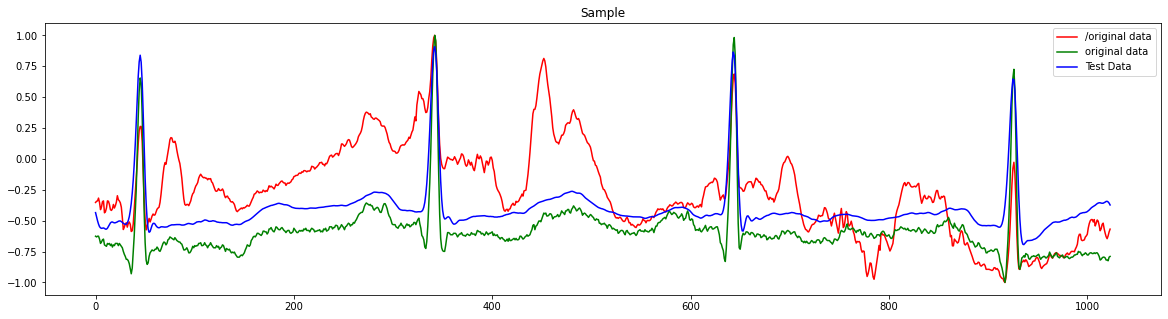

In [7]:
# Noise 06
et.ecg_plot_flat(ecg_clean_flat, ecg_noisy_flat, result, index=0)

In [8]:
# e12
# Re-align ecg_result to match with the same starting point as ecg_clean
result = et.realign_starting(result, ecg_clean_flat)

Diff: -0.19080198648551777
-0.6257309941520464 - -0.6257309941520464
-0.6257309941520464 - -0.6257309941520464


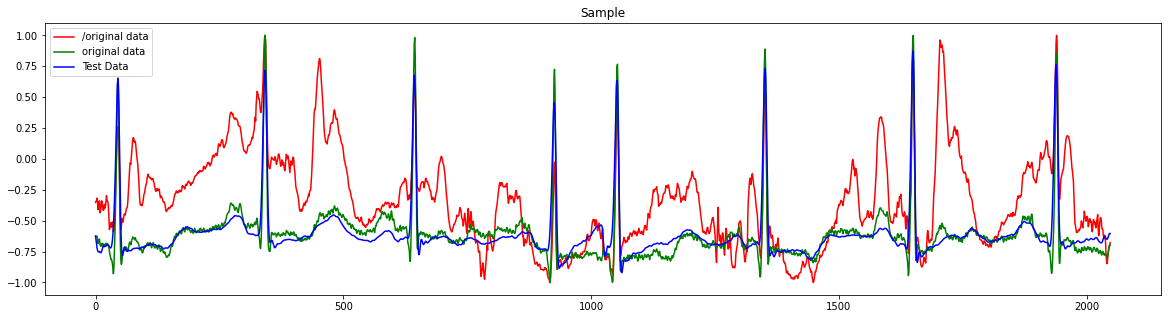

In [13]:
# e06
# et.ecg_plot_flat(ecg_clean_flat, ecg_noisy_flat, result, length=2048, index=0)
et.ecg_plot( [ecg_clean_flat, ecg_noisy_flat, result])

In [10]:
snr_a = eva.get_snr_imp(ecg_clean_flat, ecg_noisy_flat, result, True)

2.53 = 4.87 - 2.33


In [11]:
def compute_snr_imp(ecg_clean, ecg_noisy, ecg_denoised):
    # iSNR = 10 * log10 ( sum( abs(orig(:) - noisy(:)) ^ 2) / sum( abs(orig(:) - restored(:) ^ 2)))
    numer = 0
    denom = 0
    result = 0

    for i in range( len(ecg_clean) ):
        numer = numer + abs( (ecg_clean[i] - ecg_noisy[i]))

    return result